In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import datetime

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

## Load and clean data

In [3]:
meta = pd.read_excel("../DB Articoli V4.xlsx", encoding="utf8", 
                     error_bad_lines=False)
#, dtype={'Data': datetime}
meta = meta.replace(np.nan, '', regex=True)

In [4]:
article_id = meta['ID']
print ("Numero totale di articoli: %d" % len(article_id))

Numero totale di articoli: 2138


In [5]:
meta['Data'] = pd.to_datetime(meta['Data'])

In [6]:
trend1 = []
for i in meta['Trend 1']:
    trend1.append(i)

Trend = []
for i in range(len(article_id)):
    l = []
    if len(trend1[i]): l.append(trend1[i])

    Trend.append(', '.join(map(str, list(l)))) 
    
Trend[0]

'Decarbonization & Transition to Renewable & New Sources of Energy'

In [7]:
# Create Tech Dataframe
trend = pd.DataFrame({'ID': article_id, 'Trend': Trend})
trend.head()

,ID,Trend
0,2b62c9c3c72cdf9219cde304910ba6f1,Decarbonization & Transition to Renewable & New Sources of Energy
1,fc904ef82779aaa9114df97e8284102a,Open Innovation
2,39c4b22ec26c42bb7d362fd29640af33,Exponential Medicine & Digital Health
3,9ebbc6b5ee19c55075ae8d971a9efeff,Rapid Urbanization and Smart Cities
4,f86f243a8dcef8cc2e88c5e76cd0fdee,Open Innovation


In [8]:
articoli = meta[['ID','Titolo', 'Data', 'Testo']]
articoli = pd.merge(articoli, trend, on = 'ID')

In [9]:
# remove samples with no tags
articoli['Trend'] = articoli['Trend'].apply(lambda y: '' if len(y)==0 else y)
articoli = articoli[~(articoli['Trend'].str.len() == 0)]
articoli = articoli[~(articoli['Testo'].str.len() == 0)]
articoli = articoli.dropna(subset=['Data'])

In [10]:
len(articoli)
print ("Numero totale di articoli: %d" % len(articoli))

Numero totale di articoli: 2170


In [11]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    text = re.sub(r'[?|!|\'|"|#]',r'',text)
    text = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    text = text.replace("\n"," ")
    
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [12]:
articoli['Clean_Titolo'] = articoli['Titolo'].apply(lambda x: clean_text(x))
articoli['Clean_Testo'] = articoli['Testo'].apply(lambda x: clean_text(x))

In [13]:
print ("Numero totale di articoli: %d" % len(articoli))

Numero totale di articoli: 2170


In [14]:
#articoli.head()
#articoli.sample(5, random_state=0)

## Remove stopwords from data

In [15]:
from nltk.corpus import stopwords

stop_words = nltk.corpus.stopwords.words('english')
my_stopwords = ['also','said', 'one', 'may', 'polls', 'sorry', 'like', 'use', 'many', 'make', 'could', 
                'even', 'says', 'new', 'us', 'would', 'time', 'companies', 'moment', 'way', 'using', 'two',
               'across', 'well', 'world', 'first', 'system', 'million', 'systems', 'including', 'example', 'year', 
                'based', 'googletagcmdpushfunction', 'th']
stop_words.extend(my_stopwords)

In [16]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [17]:
articoli['Clean_Titolo'] = articoli['Clean_Titolo'].apply(lambda x: remove_stopwords(x))
articoli['Clean_Testo'] = articoli['Clean_Testo'].apply(lambda x: remove_stopwords(x))

In [18]:
articoli['Txt'] = articoli['Clean_Titolo'] + " " + articoli['Clean_Testo']
del(articoli['Clean_Titolo'])
del(articoli['Clean_Testo'])

## Feature Engineering

In [19]:
def extract_date(df,column):
    df["Anno"] = df[column].apply(lambda x: x.year)
    df["Mese"] = df[column].apply(lambda x: x.month)
    df["Day"] = df[column].apply(lambda x: x.day)
    
extract_date(articoli, "Data")

In [20]:
def extract_week_number(df, column):
    df["Week"] = df[column].apply(lambda x: datetime.date(int(x.year), int(x.month), int(x.day)).strftime("%V"))
    #datetime.date(articoli['Data'][0].year, articoli['Data'][0].month , articoli['Data'][0].day).strftime("%V")
    
extract_week_number(articoli, "Data")

In [21]:
#articoli.head()

## Extract keywords for each row

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import re
## Remove stopwords from data
corpus = articoli['Txt']
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [23]:
#https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# get feature names
feature_names=cv.get_feature_names()

In [24]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [25]:
def extract_keys_for_row(doc, n):  
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    
    #extract only the top n
    keywords=extract_topn_from_vector(feature_names,sorted_items, n)
    
    kw = []
    for k in keywords:
        kw.append(k)
        
    return ", ".join(kw)
        
#extract_keys_for_row(articoli['Txt'][1], 25)

In [26]:
# TODO man mano che aumentano gli articoli sarà sempre più lungo: vanno estratti in un file separato
articoli['Keywords'] = articoli['Txt'].apply(lambda x: extract_keys_for_row(x,25))

In [27]:
#articoli.head()

In [28]:
print ("articoli senza keyword: %d" % articoli['Keywords'].isnull().values.sum())

articoli senza keyword: 0


## Apply tags to keywords

In [29]:
tags = pd.read_excel("Keywords to Tags V4.xlsx", encoding="utf8", error_bad_lines=False)
tags = tags.replace(np.nan, '', regex=True)
del(tags['Tag 1'])
del(tags['Tag 2'])
del(tags['Tag 3'])

In [30]:
tags = tags[~(tags['Tags'].str.len() == 0)]

In [31]:
tags.describe()

,Words,Tags
count,925,925
unique,922,380
top,ios,"Vertical: Finance, Tag: Venture Capital"
freq,2,37


In [32]:
keywords = articoli[['ID','Keywords']]
keywords.head()

,ID,Keywords
0,2b62c9c3c72cdf9219cde304910ba6f1,"battery, flexible, thin film, ipi, thin, film, charge, technology, strategic planning, fast, flex, korean, wearables, fabric, find, networking, session, suitable, please, freedom, internet things, newly, enterprises, military, singapore"
1,fc904ef82779aaa9114df97e8284102a,"start ups, ups, start, innovation, ipi, product development, experts, product, technical, development, challenges, flex, grapple, journeys, district, particularly important, open innovation, smooth, market, industry, shorter, session, lee, engaging, pain"
2,39c4b22ec26c42bb7d362fd29640af33,"prostate, invasive, fertility, non invasive, cancer, test, non, tests, accurate, arteries, cancer cells, method, female, device, diagnose, detect, medical, flow, positioned, phases, patients, woman, besides, fluid, cells"
3,9ebbc6b5ee19c55075ae8d971a9efeff,"singapore, collaboration, smart, programme, building, ipi, business, solutions, participants, hub, event, innovative, technologies, robotics, successful, innovative solutions, yet another, appreciate, assembled, technology, returned, look forward, debut, pitch, advisor"
4,f86f243a8dcef8cc2e88c5e76cd0fdee,"workshop, technology transfer, transfer, technology, ipi, director, participants, held, dont, sze, office, goh, lin, licensing, dr, holistic, intellectual property, exercises, deputy, commented, ip, academia, programme, valuation, know"


In [33]:
words = pd.concat([pd.Series(row['ID'], row['Keywords'].split(', ')) 
           for _, row in keywords.iterrows()]).reset_index().rename(columns={"index": "Words", 0: "ID"})
words.sort_values(by=['Words'], inplace=True)

In [34]:
words.describe()
#words.to_csv('prova.csv', sep=";")

,Words,ID
count,53788,53788
unique,8603,2118
top,ai,d707d1d5310c1151cc2cd04b1931c234
freq,243,100


In [35]:
res = tags.merge(words, on="Words", how='left')

In [36]:
res.head()
#res.to_csv('prova.csv', sep=";")

,Words,Tags,ID
0,aarogya setu,"Tech: Mobile app, Tag: Development, Application: Contact Tracing",NaN
1,academic,Vertical: University,c22099e985da4914f7e1381fbb3472bb
2,academic,Vertical: University,cf4a502cbc3be4bf184002d5db67ac81
3,academic,Vertical: University,036811f34226f83b8533276668044a4c
4,academic,Vertical: University,c3867e2ca29ffade71f104301bf2a743


In [37]:
res = res.groupby('ID').agg(lambda x: x.tolist()).rename({'Tags': 'ComputedTags'}, axis=1)

In [38]:
def list_to_csv(text):
    str_list = ", " . join(text)

    str_list = str_list.split(", ")
    str_list = list(map(str.strip, str_list))
    str_list = list(filter(None, str_list))
    str_list = list(set(str_list))
    str_list = ", " . join(str_list)
    
    return str_list
    
list_to_csv(res['ComputedTags'][1])

'Vertical: Technology, Company: Apple, Vertical: Banking'

In [39]:
res['ComputedTags'] = res['ComputedTags'].apply(lambda x: list_to_csv(x))

In [40]:
res.head()

,Words,ComputedTags
ID,,
0041230019f3679d60b2900af083d41d,"[astronomers, black hole, european]","Tag: Black Swan, Vertical: Space, Location: Europe"
0058547b6941eb5d98ce49d5ec448d00,"[apple, banks]","Vertical: Technology, Company: Apple, Vertical: Banking"
005b6d185b27aa2b15483734fac9c657,"[america, clean power, energy, financing, renewable, renewable, renewable energy, renewable energy, solar, solar energy, solar powered, truck]","Application: Renewables, Vertical: Energy & Utility, Tag: Solar, Location: North America, Tag: Green Power, Vertical: Transportation, Vertical: Finance"
008add2b66153dfd0512bf8611f3b815,[remote working],Application: Smart Working
00b4785a7e2de5a5df9b6ee9adba52e7,"[florida, global warming, tesla]","Location: Florida, Vertical: Automotive, Company: Tesla, Tag: Global Warming"


In [41]:
articoli = articoli.merge(res, on="ID", how='left')
articoli = articoli.replace(np.nan, '', regex=True)

In [42]:
articoli.head(2)

,ID,Titolo,Data,Testo,Trend,Txt,Anno,Mese,Day,Week,Keywords,Words,ComputedTags
0,2b62c9c3c72cdf9219cde304910ba6f1,Flexible Thin-film Fast Charge Battery...,2018-12-05,"With the rise of Internet of Things and wearables, batteries have taken on new form factors to meet the different market requirements such as power, flexibility and thinness. At a technology roundtable organised by IPI on 27 November 2018, EJ Shin, Strategic Planning Director of Jenax Inc., pres...",Decarbonization & Transition to Renewable & New Sources of Energy,flexible thin film fast charge battery rise internet things wearables batteries taken form factors meet different market requirements power flexibility thinness technology roundtable organised ipi november ej shin strategic planning director jenax inc presented latest flexible thin film fast cha...,2018,12,5,49,"battery, flexible, thin film, ipi, thin, film, charge, technology, strategic planning, fast, flex, korean, wearables, fabric, find, networking, session, suitable, please, freedom, internet things, newly, enterprises, military, singapore","[battery, internet things, korean, military, singapore, technology, wearables]","Location: Korea, Location: Singapore, Application: Energy Storage, Tech: Wearables, Tag: Military, Tech: IoT, Tag: Technology, Tech: Batteries"
1,fc904ef82779aaa9114df97e8284102a,Connecting Start-ups to Technical Experts via...,2019-02-01,"Start ups grapple with numerous challenges and the path to success is often gruelling. For many technology start ups, product innovation and development are particularly important components to gain a competitive advantage in the market. As part of its efforts to engage the hardware and engineer...",Open Innovation,connecting start ups technical experts via start ups grapple numerous challenges path success often gruelling technology start ups product innovation development particularly important components gain competitive advantage market part efforts engage hardware engineering start ups singapore enhan...,2019,2,1,05,"start ups, ups, start, innovation, ipi, product development, experts, product, technical, development, challenges, flex, grapple, journeys, district, particularly important, open innovation, smooth, market, industry, shorter, session, lee, engaging, pain","[development, innovation, product development, start ups]","Tag: Innovation, Tag: Development, Tag: Startup"


In [43]:
print ("articoli senza keyword: %d" % articoli['ComputedTags'].isnull().values.sum())

articoli senza keyword: 0


In [44]:
def count_tags(tags):
    tag_list = tags.split(",")
    
    #deduplica
    tag_list = list(map(str.strip, tag_list))
    tag_list = list(filter(None, tag_list))
    tag_list = list(set(tag_list))
    
    return (len(tag_list))
    
count_tags(articoli['ComputedTags'][0])

8

In [45]:
articoli['NumberOfTags'] = articoli['ComputedTags'].apply(lambda x: count_tags(x))

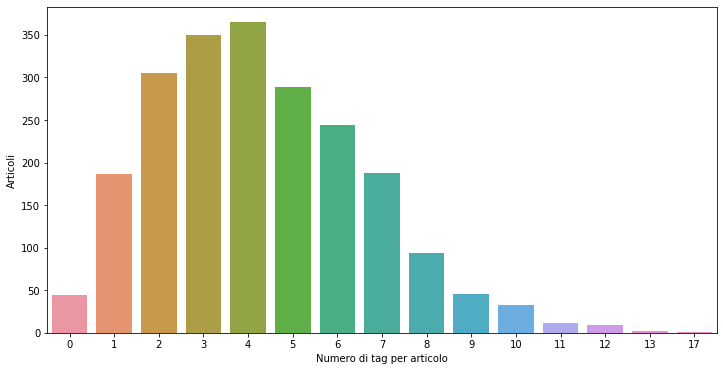

In [46]:
plt.figure(figsize=(12,6))
ax=sns.countplot(articoli["NumberOfTags"])
plt.xlabel("Numero di tag per articolo")
plt.ylabel("Articoli")
plt.show()

In [47]:
#articoli.to_csv('prova.csv', sep=";")

## Split tags in columns

In [48]:
## Extract keywords for each row
def get_tags_types(tags):
    tag_types = []
    for tag in tags:
        t1 = tag.split(",")[0]
        if len(t1):
            t2 = t1.split(":")[0]
            tag_types.append(t2)
            
    tag_types = list(map(str.strip, tag_types))
    tag_types = list(filter(None, tag_types))
    tag_types = list(set(tag_types))
    
    return tag_types
    
get_tags_types(articoli['ComputedTags'])

['Company', 'Tag', 'Vertical', 'Tech', 'Application', 'Location']

In [49]:
def split_tags_in_columns(tags, column):
    tag_list = tags.split(",")

    tag = []
    for t in tag_list:
        if t.split(":")[0].strip() == column:
            tag.append(t.split(":")[1].strip())
            #return t.split(":")[1].strip()
        
    str_tag = ", " . join(tag)
    return str_tag
    
split_tags_in_columns(articoli['ComputedTags'][4], 'Tech')

''

In [50]:
for tt in get_tags_types(articoli['ComputedTags']):
    articoli[tt] = articoli['ComputedTags'].apply(lambda x: split_tags_in_columns(x, tt))

In [51]:
articoli.head(1)

,ID,Titolo,Data,Testo,Trend,Txt,Anno,Mese,Day,Week,Keywords,Words,ComputedTags,NumberOfTags,Company,Tag,Vertical,Tech,Application,Location
0,2b62c9c3c72cdf9219cde304910ba6f1,Flexible Thin-film Fast Charge Battery...,2018-12-05,"With the rise of Internet of Things and wearables, batteries have taken on new form factors to meet the different market requirements such as power, flexibility and thinness. At a technology roundtable organised by IPI on 27 November 2018, EJ Shin, Strategic Planning Director of Jenax Inc., pres...",Decarbonization & Transition to Renewable & New Sources of Energy,flexible thin film fast charge battery rise internet things wearables batteries taken form factors meet different market requirements power flexibility thinness technology roundtable organised ipi november ej shin strategic planning director jenax inc presented latest flexible thin film fast cha...,2018,12,5,49,"battery, flexible, thin film, ipi, thin, film, charge, technology, strategic planning, fast, flex, korean, wearables, fabric, find, networking, session, suitable, please, freedom, internet things, newly, enterprises, military, singapore","[battery, internet things, korean, military, singapore, technology, wearables]","Location: Korea, Location: Singapore, Application: Energy Storage, Tech: Wearables, Tag: Military, Tech: IoT, Tag: Technology, Tech: Batteries",8,,"Military, Technology",,"Wearables, IoT, Batteries",Energy Storage,"Korea, Singapore"


In [52]:
#articoli.to_csv('prova.csv', sep=";", encoding = "utf-8")

## Save assets

In [53]:
import pickle
with open('stop_words', 'wb') as stopwords_dump:
    pickle.dump(stop_words, stopwords_dump)

In [54]:
output_filename = 'temp/db'
articoli.to_csv(output_filename, sep=";")